# Modèle de classement des textos en spam

Dans ce cas pratique on cherche à entraîner un modèle capable de prédire si un texto est un spam ou non. On s'appuie pour cela sur une base de données contenant des sms labellisés comme spam ou non spam (trouvée sur https://archive.ics.uci.edu/ml/datasets.php, voir readme pour plus d'informations).  

- Importez la base de données dans un dataframe 

- Appliquez les transformations usuelles du texte pour faciliter l'analyse textuelle

- Faites une matrice de termes et affichez les termes les plus fréquents dans chaque catégorie : spam ou non spam. Si nécessaire, enrichissez la liste de stop-words pour limiter la taille de la matrice.

- Faites un nuage de mots par catégorie pour bien illustrer les différences des mots utilisés entre spam et non spam.

- À partir de la matrice de termes réduite, entraînez un modèle de forêts aléatoires permettant de prédire si un texto est un spam ou non 

- Essayez d'améliorer la prédiction de votre modèle en ajoutant une analyse en composantes principales en amont.

On peut imaginer que pour une entreprise qui développe cette solution, on souhaite plus à minimiser l'erreur consistant à définir comme spam un texto qui n'en est pas un (erreur de type 1, "faux positif") plutôt que de rater quelques spams : 
- Utilisez votre dernier modèle pour prédire des probabilités que le texto soit un spam. À partir de quelle valeur de cette probabilité notre modèle ne classe aucun non spam en spam?

In [1]:
#numpy
import numpy as np
import os
os.chdir("/Users/charleshajjar/Downloads/")


In [2]:
#importation of the corpus
import pandas as pd
spams = pd.read_table("/Users/charleshajjar/Downloads/SMSSpamCollection.txt",sep="\t",header=0)


In [3]:
spams.head()

,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
0,ham,Ok lar... Joking wif u oni...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,U dun say so early hor... U c already then say...
3,ham,"Nah I don't think he goes to usf, he lives aro..."
4,spam,FreeMsg Hey there darling it's been 3 week's n...


In [4]:
spams.columns = ['message', 'texte']

In [5]:
#type of the object
print(type(spams))


<class 'pandas.core.frame.DataFrame'>


In [6]:
#size of the dataset
print(spams.shape)

(5571, 2)


In [7]:
#list of columns
print(spams.columns)

Index(['message', 'texte'], dtype='object')


In [8]:
#type of columns
print(spams.dtypes)

message    object
texte      object
dtype: object


In [9]:
#description
print(spams.describe())

       message                   texte
count     5571                    5571
unique       2                    5168
top        ham  Sorry, I'll call later
freq      4824                      30


In [10]:
#frequency distribution of the class attribute
print(pd.crosstab(index=spams["message"],columns="count"))
 

col_0    count
message       
ham       4824
spam       747


In [11]:
#metrics.f1_score(y_test, y_pred)

In [12]:
import re
import string

# On définit une fonction qui fait tout ça pour directement l'appliquer aux hommes et aux femmes : 
def premier_nettoyage(text):
    text = text.lower() # passage en minuscules
    text = re.sub("\([0-9][0-9]e\)", "", text) # On enlève les références au minutages
    text = re.sub("\([0-9]-[0-9]\)", " ", text) # références aux scores
    text = re.sub(f"[{string.punctuation}]", " ", text) # on enlève la ponctuation  
    text = re.sub("〨", "", text) 
    text = re.sub("week", "", text)
    text = re.sub("[0-9]", "", text)
    text = re.sub(r"\xa0", " ", text)
    text = re.sub(r"\xa0", " ", text)# caractère spécial hypertexte
    return text

spams["texte"] = spams.texte.apply(lambda x: premier_nettoyage(x))
spams_text = spams

In [13]:
def second_nettoyage(text):
    text = re.sub("[0-9]", "", text) # On enlève les références au minutages
    return text
spams_text = pd.DataFrame(spams_text.texte.apply(lambda x: second_nettoyage(x)))

In [14]:
spams_mess=spams["message"]

In [15]:
spams_text

,texte
0,ok lar joking wif u oni
1,free entry in a wkly comp to win fa cup final...
2,u dun say so early hor u c already then say
3,nah i don t think he goes to usf he lives aro...
4,freemsg hey there darling it s been s now an...
...,...
5566,this is the nd time we have tried contact u ...
5567,will ü b going to esplanade fr home
5568,pity was in mood for that so any other s...
5569,the guy did some bitching but i acted like i d...


In [16]:
spams_all=pd.concat([spams_mess, spams_text], axis=1)

In [17]:
spams_all

,message,texte
0,ham,ok lar joking wif u oni
1,spam,free entry in a wkly comp to win fa cup final...
2,ham,u dun say so early hor u c already then say
3,ham,nah i don t think he goes to usf he lives aro...
4,spam,freemsg hey there darling it s been s now an...
...,...,...
5566,spam,this is the nd time we have tried contact u ...
5567,ham,will ü b going to esplanade fr home
5568,ham,pity was in mood for that so any other s...
5569,ham,the guy did some bitching but i acted like i d...


In [18]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopWords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/charleshajjar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
newStopWords = ['.','’','','»',
                'Le',',','«','a','–','(',')','aa','aah','ab','zf','èn','th','zs','aaooooright',]

In [20]:
stopWords = set(stopwords.words('english') + newStopWords)

In [21]:
#tokenizer = nltk.RegexpTokenizer('[a-zA-Z]{4,}')

In [22]:
def review_messages(msg):
    # converting messages to lowercase
    msg = msg.lower()
    return msg

In [23]:
from nltk import stem
from nltk.corpus import stopwords
stemmer = stem.SnowballStemmer('english')
stopwords = set(stopwords.words('english'))

def alternative_review_messages(msg):
    # converting messages to lowercase
    msg = msg.lower()
    # removing stopwords
    msg = [word for word in msg.split() if word not in stopWords]
    # using a stemmer
    msg = " ".join([stemmer.stem(word) for word in msg])
    return msg

In [24]:
spams_all

,message,texte
0,ham,ok lar joking wif u oni
1,spam,free entry in a wkly comp to win fa cup final...
2,ham,u dun say so early hor u c already then say
3,ham,nah i don t think he goes to usf he lives aro...
4,spam,freemsg hey there darling it s been s now an...
...,...,...
5566,spam,this is the nd time we have tried contact u ...
5567,ham,will ü b going to esplanade fr home
5568,ham,pity was in mood for that so any other s...
5569,ham,the guy did some bitching but i acted like i d...


In [25]:
spams_all['texte'] = spams['texte'].apply(review_messages)

In [26]:
spams_all['texte']

0                           ok lar    joking wif u oni   
1       free entry in  a wkly comp to win fa cup final...
2       u dun say so early hor    u c already then say   
3       nah i don t think he goes to usf  he lives aro...
4       freemsg hey there darling it s been   s now an...
                              ...                        
5566    this is the nd time we have tried  contact u  ...
5567                 will ü b going to esplanade fr home 
5568    pity    was in mood for that  so   any other s...
5569    the guy did some bitching but i acted like i d...
5570                           rofl  its true to its name
Name: texte, Length: 5571, dtype: object

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(spams_all['texte'], spams_all['message'], test_size = 0.1, random_state = 1)
# training the vectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)

In [28]:
from sklearn import svm
svm = svm.SVC(C=1000)
svm.fit(X_train, y_train)

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [29]:
from sklearn.metrics import confusion_matrix
X_test = vectorizer.transform(X_test)
y_pred = svm.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[489   0]
 [  6  63]]


In [30]:
#f1_score(y_test, y_pred)

In [31]:
spams_all= spams_all.replace({"spam":"1","ham":"0"})

In [32]:
spams_all

,message,texte
0,0,ok lar joking wif u oni
1,1,free entry in a wkly comp to win fa cup final...
2,0,u dun say so early hor u c already then say
3,0,nah i don t think he goes to usf he lives aro...
4,1,freemsg hey there darling it s been s now an...
...,...,...
5566,1,this is the nd time we have tried contact u ...
5567,0,will ü b going to esplanade fr home
5568,0,pity was in mood for that so any other s...
5569,0,the guy did some bitching but i acted like i d...


In [33]:
group = spams_all.groupby('message')
text=group.sum()
text

,texte
message,
0,ok lar joking wif u oni u dun say so earl...
1,free entry in a wkly comp to win fa cup final...


In [34]:
hom= text.loc['0', 'texte']
hom

'ok lar    joking wif u oni   u dun say so early hor    u c already then say   nah i don t think he goes to usf  he lives around here thougheven my brother is not like to speak with me  they treat me like aids patent as per your request  melle melle  oru minnaminunginte nurungu vettam   has been set as your callertune for all callers  press   to copy your friends callertunei m gonna be home soon and i don t want to talk about this stuff anymore tonight  k  i ve cried enough today i ve been searching for the right words to thank you for this breather  i promise i wont take your help for granted and will fulfil my promise  you have been wonderful and a blessing at all times i have a date on sunday with will  oh k   i m watching here  eh u remember how  spell his name    yes i did  he v naughty make until i v wet fine if that\x92s the way u feel  that\x92s the way its gota bis that seriously how you spell his name i‘m going to try for  months ha ha only jokingso ü pay first lar    then wh

In [35]:
spam= text.loc['1', 'texte']
spam

'free entry in  a wkly comp to win fa cup final tkts st may   text fa to  to receive entry question std txt rate t c s apply over sfreemsg hey there darling it s been   s now and no word back  i d like some fun you up for it still  tb ok  xxx std chgs to send  £  to rcvwinner   as a valued network customer you have been selected to receivea £ prize reward  to claim call   claim code kl  valid  hours only had your mobile  months or more  u r entitled to update to the latest colour mobiles with camera for free  call the mobile update co free on six chances to win cash  from  to   pounds txt  csh and send to   cost p day  days    tsandcs apply reply hl  infourgent  you have won a   free membership in our £  prize jackpot  txt the word  claim to no   t c www dbuk net lccltd pobox ldnwarwxxxmobilemovieclub  to use your credit  click the wap link in the next txt message or click here   http   wap  xxxmobilemovieclub com n qjkgighjjgcblengland v macedonia   dont miss the goals team news  txt 

In [36]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words = stopWords)

# On fit_transform 
cr_cv = cv.fit_transform(text.texte)
cr_dtm = pd.DataFrame(cr_cv.toarray(), columns = cv.get_feature_names())
cr_dtm.index = text.index
cr_dtm

/Users/charleshajjar/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['le'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,aaniye,aathi,abbey,abdomen,abeg,abel,aberdeen,abi,ability,abiola,...,zeros,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada,ènugh,üshall
message,,,,,,,,,,,,,,,,,,,,,
0,1,5,1,1,1,1,0,4,2,2,...,1,1,2,1,1,1,0,1,1,1
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0


In [38]:
spams_analyse = cr_dtm.transpose()
spams_analyse.head(20)

message,0,1
aaniye,1,0
aathi,5,0
abbey,1,0
abdomen,1,0
abeg,1,0
abel,1,0
aberdeen,0,1
abi,4,0
ability,2,0
abiola,2,0


In [39]:
spams_analyse["0"].sort_values(ascending = False).head(20)

gt       318
lt       316
get      305
go       252
ur       247
ok       235
know     231
like     229
got      228
call     228
come     225
good     219
day      205
love     198
time     196
going    167
one      164
want     162
lor      162
need     158
Name: 0, dtype: int64

In [40]:
spams_analyse["1"].sort_values(ascending = False).head(20)

call       349
free       204
txt        168
ur         135
mobile     127
text       120
stop       117
claim      112
reply      102
www         98
prize       93
get         85
cash        76
nokia       71
send        68
new         68
uk          64
win         61
tone        58
contact     56
Name: 1, dtype: int64

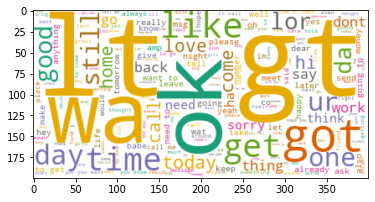

In [41]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(stopwords=stopWords, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

wc.generate(text.texte["0"])

plt.imshow(wc, interpolation="bilinear")
plt.show()

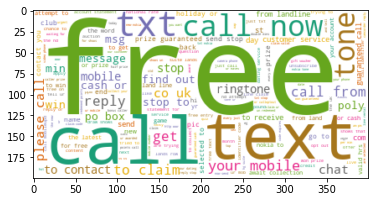

In [42]:
wc.generate(text.texte["1"])

plt.imshow(wc, interpolation="bilinear")
plt.show()

In [47]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [46]:
rfc = RandomForestClassifier(n_estimators=300, random_state=90)
rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)
acc = accuracy_score(y_test, rfc_pred)
print ("Accuracy Score:", acc.round(3))



Accuracy Score: 0.984


In [48]:

print(classification_report(y_test, rfc_pred))


              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       489
        spam       1.00      0.87      0.93        69

    accuracy                           0.98       558
   macro avg       0.99      0.93      0.96       558
weighted avg       0.98      0.98      0.98       558

